In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import xmltodict


In [5]:
# img=plt.imread("mask1.png")
# img=img.astype("bool")
# plt.imshow(img.astype('float32'))

In [6]:
images=os.listdir("images/")
images[:3],len(images)

(['image0.png', 'image1.png', 'image10.png'], 1255)

In [7]:
masks=os.listdir("masks/")
masks[:3],len(masks)

(['mask0.png', 'mask1.png', 'mask10.png'], 1255)

In [41]:
def overlap(img,mask):
    img=np.interp(img[:,:,:3],[0.0,1.0],[0,255])
    img=img.astype("uint8")
    mask=np.interp(mask,[0.0,1.0],[0,255])
    mask=mask[:,:,0].astype("uint8")
    
    # mask=mask[:,:,0]
    rows,cols=np.where(mask>=255)
    idx=list(zip(rows,cols))
    for i in idx:
        img[i[0]][i[1]]=[0,255,0]
    plt.imshow(img)


In [42]:
n=3
img=plt.imread("images/"+images[n])
mask=plt.imread("masks/"+masks[n])

In [43]:
img.shape,img.dtype


((200, 200, 4), dtype('float32'))

In [44]:
mask.shape,mask.dtype


((200, 200, 4), dtype('float32'))

In [45]:
img.max()

1.0

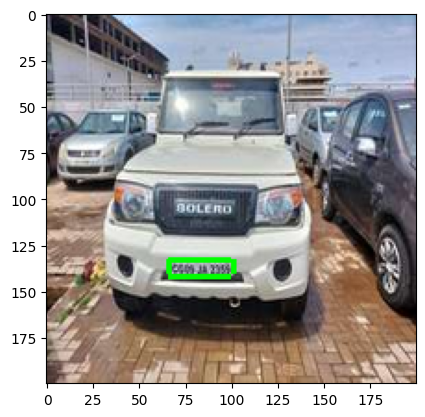

In [46]:
overlap(img,mask)


In [47]:
def create_dataset(img_path,mask_path):
    img_size=192
    images=os.listdir(img_path)
    masks=os.listdir(mask_path)
    
    count=len(images)
    xtrain=np.zeros((count,img_size,img_size,3),dtype=np.uint8)
    ytrain=np.zeros((count,img_size,img_size,1),dtype=np.uint8)
    
    
    for i in tqdm(range(len(images))):
        # resizeing
        img=plt.imread(img_path+images[i])
        img=img[:,:,:3]
        img=np.interp(img,[0.0,1.0],[0,255])
        img=img.astype("uint8")
        img=Image.fromarray(img)
        img=img.resize((img_size,img_size),Image.LANCZOS)
        img=np.array(img)
        
        
        mask=Image.open(mask_path+masks[i])
        mask=np.array(mask.resize((img_size,img_size),Image.LANCZOS))
        mask=mask[:,:,0:1]       
        mask=np.interp(mask,[0.0,1.0],[0,255])
        mask=mask.astype("uint8")        
        
        # mask=np.expand_dims(mask,axis=-1)
        
        # mask=np.array(mask)

        xtrain[i]=img
        ytrain[i]=mask

    return xtrain,ytrain
        
        

    

In [54]:
x,y=create_dataset("images/","masks/")

100%|██████████████████████████████████████████████████████████████████████████████| 1255/1255 [00:16<00:00, 77.94it/s]


In [55]:
x.shape,x.dtype

((1255, 192, 192, 3), dtype('uint8'))

In [56]:
y.shape,y.dtype


((1255, 192, 192, 1), dtype('uint8'))

In [116]:
# plt.imshow(x[8][72:96,25:78,:])
# x[8][72:96,25:78,:].shape

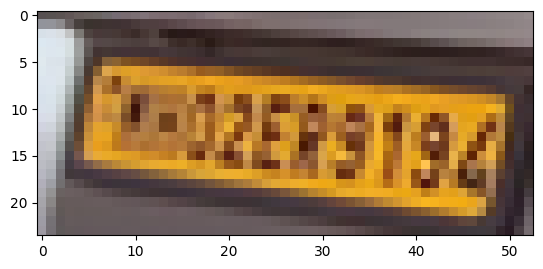

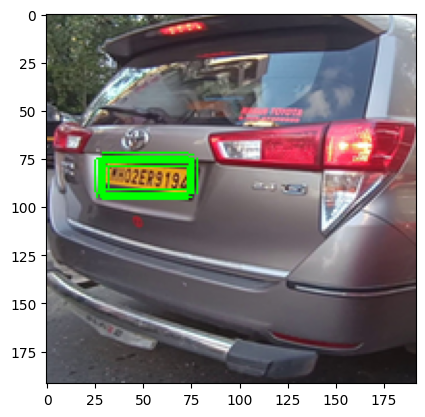

In [115]:
overlap(x[8],y[8])
# x[0].shape

In [117]:
y=np.array(y,dtype=np.bool_)
y.shape,y.dtype


((1255, 192, 192, 1), dtype('bool'))

In [84]:
# plt.imshow(y[3])
# if(y[300].all()==y[1].all()):
#     print(True)

In [15]:
# Model training

In [118]:
inp=layers.Input((192,192,3))

# Downsampling
d1=layers.Conv2D(32,(3,3),activation="relu",padding='same')(inp)
d1=layers.Dropout(0.2)(d1)
d1=layers.Conv2D(32,(3,3),activation="relu",padding='same')(d1)

m1=layers.MaxPooling2D((2,2))(d1)

d2=layers.Conv2D(64,(3,3),activation="relu",padding='same')(m1)
d2=layers.Dropout(0.2)(d2)
d2=layers.Conv2D(64,(3,3),activation="relu",padding='same')(d2)

m2=layers.MaxPooling2D((2,2))(d2)

d3=layers.Conv2D(128,(3,3),activation="relu",padding='same')(m2)
d3=layers.Dropout(0.2)(d3)
d3=layers.Conv2D(128,(3,3),activation="relu",padding='same')(d3)

m3=layers.MaxPooling2D((2,2))(d3)

d4=layers.Conv2D(256,(3,3),activation="relu",padding='same')(m3)
d4=layers.Dropout(0.2)(d4)
d4=layers.Conv2D(256,(3,3),activation="relu",padding='same')(d4)

m4=layers.MaxPooling2D((2,2))(d4)

# Bottle neck
d5=layers.Conv2D(512,(3,3),activation="relu",padding='same')(m4)
d5=layers.Dropout(0.2)(d5)
d5=layers.Conv2D(512,(3,3),activation="relu",padding='same')(d5)

# Upsampling 
u1=layers.UpSampling2D((2,2))(d5)
u1=layers.concatenate([d4,u1])
u1=layers.Conv2D(256,(3,3),activation="relu",padding='same')(u1)
u1=layers.Dropout(0.2)(u1)
u1=layers.Conv2D(256,(3,3),activation="relu",padding='same')(u1)

u2=layers.UpSampling2D((2,2))(u1)
u2=layers.concatenate([d3,u2])
u2=layers.Conv2D(128,(3,3),activation="relu",padding='same')(u2)
u2=layers.Dropout(0.2)(u2)
u2=layers.Conv2D(128,(3,3),activation="relu",padding='same')(u2)

u3=layers.UpSampling2D((2,2))(u2)
u3=layers.concatenate([d2,u3])
u3=layers.Conv2D(64,(3,3),activation="relu",padding='same')(u3)
u3=layers.Dropout(0.2)(u3)
u3=layers.Conv2D(64,(3,3),activation="relu",padding='same')(u3)

u4=layers.UpSampling2D((2,2))(u3)
u4=layers.concatenate([d1,u4])
u4=layers.Conv2D(32,(3,3),activation="relu",padding='same')(u4)
u4=layers.Dropout(0.2)(u4)
u4=layers.Conv2D(32,(3,3),activation="relu",padding='same')(u4)

# Output
output=layers.Conv2D(1,(1,1),activation="sigmoid")(u4)

model = models.Model(inputs=[inp], outputs=[output])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 192, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 192, 192, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [120]:
model.fit(x,y,epochs=10,batch_size=8,verbose=1,validation_split=0.2)

Epoch 1/10
126/126 [==============================] - 37s 255ms/step - loss: 0.1261 - accuracy: 0.9792 - val_loss: 0.1063 - val_accuracy: 0.9784
Epoch 2/10
126/126 [==============================] - 27s 218ms/step - loss: 0.0867 - accuracy: 0.9796 - val_loss: 0.0886 - val_accuracy: 0.9784
Epoch 3/10
126/126 [==============================] - 28s 219ms/step - loss: 0.0732 - accuracy: 0.9797 - val_loss: 0.0818 - val_accuracy: 0.9784
Epoch 4/10
126/126 [==============================] - 28s 220ms/step - loss: 0.0613 - accuracy: 0.9796 - val_loss: 0.0740 - val_accuracy: 0.9784
Epoch 5/10
126/126 [==============================] - 28s 220ms/step - loss: 0.0531 - accuracy: 0.9797 - val_loss: 0.0619 - val_accuracy: 0.9784
Epoch 6/10
126/126 [==============================] - 28s 220ms/step - loss: 0.0432 - accuracy: 0.9797 - val_loss: 0.0507 - val_accuracy: 0.9784
Epoch 7/10
126/126 [==============================] - 28s 220ms/step - loss: 0.0376 - accuracy: 0.9836 - val_loss: 0.0466 - val_ac

In [122]:
# model.save("mask_app1.h5")
model=tf.keras.models.load_model("mask_app1.h5")

In [123]:
ypre=model.predict(x[200:210])

In [124]:
ypre=np.interp(ypre,[0.0,1.0],[0.0,255.0])


ypre.shape,ypre.dtype

((10, 192, 192, 1), dtype('float64'))

In [125]:
# plt.imshow(ypre[2])
ypre[7].max()

221.29044324159622

In [132]:
def overlap(img,mask):
    # img=np.interp(img[:,:,:3],[0.0,1.0],[0,255])
    # img=img.astype("uint8")
    tem_img=img.copy()
    # mask=np.interp(mask,[0.0,1.0],[0,255])
    # mask=mask[:,:,0].astype("uint8")
    
    mask=mask[:,:,0]
    rows,cols=np.where(mask>=200)
    idx=list(zip(rows,cols))
    x_min=sorted(idx,key=lambda x:x[0])[0][0]
    x_max=sorted(idx,key=lambda x:x[0])[-1][0]
    y_min=sorted(idx,key=lambda x:x[1])[0][1]
    y_max=sorted(idx,key=lambda x:x[1])[-1][1]
    # print(x_min,y_min,x_max,y_max ,type(x_min))
    
    for i in idx:
        tem_img[i[0]][i[1]]=[0,255,0]
    tem=img[x_min:x_max,y_min:y_max,:3]
    plt.imshow(tem)
    plt.show()
    plt.imshow(tem_img)


In [135]:
# overlap(x[200],y[200])

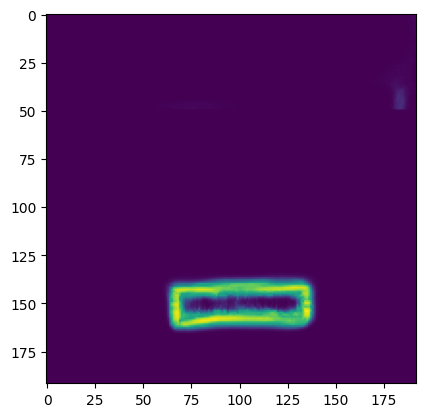

In [136]:
plt.imshow(ypre[2])

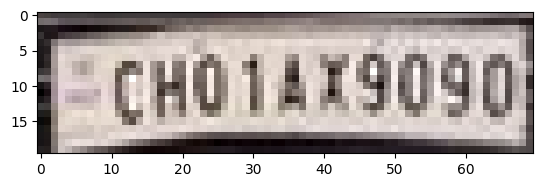

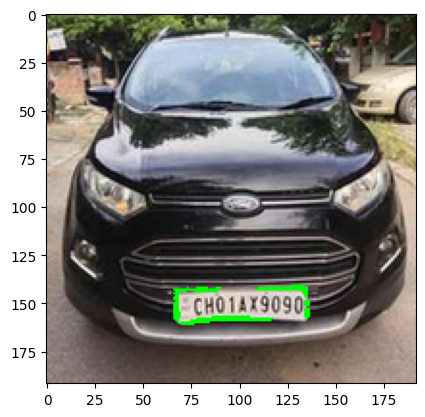

In [138]:
overlap(x[202],ypre[2])

# Data Augmentation

In [63]:
# out=post_processing([xtrain_2[202]],[ytrain_2[202]])
# ytrain_2[201].shape

In [25]:
import albumentations as A
# import cv2
# import numpy as np

E:\jupyter\tensorflow\lib\site-packages\albumentations\check_version.py:107: UserWarning: Error fetching version info <urlopen error [Errno 11001] getaddrinfo failed>
  data = fetch_version_info()


In [26]:
# Example pipeline (matches original doc for consistency with images)
train_transform = A.Compose([
    # A.RandomCrop(width=200, height=200, p=1.0), # Example random crop
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.Affine(p=1, scale=0.9, shear=5, translate_percent=0.05, rotate=15),
    A.RandomRain(p=1, rain_type="heavy", slant_range=(-30, -30)),    
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='yolo', # Specify input format
                           label_fields=['class_labels'] # Specify label argument name(s)
                           ))

# transform = A.Compose(
#     [
#         A.HorizontalFlip(p=0.5),
#         A.Affine(p=1, scale=0.8, shear=5, translate_percent=0.05, rotate=15),
#         A.RandomBrightnessContrast(p=0.3),
#         A.PlanckianJitter(p=0.5),
#         A.RandomRain(p=1, rain_type="heavy", slant_range=(-30, -30)),
#     ],
#     bbox_params=A.BboxParams(format="coco", label_fields=["category_ids"]))


In [27]:
list(ytrain_2[25])

[0.535, 0.06027, 0.29, 0.1064]

In [41]:
aug=train_transform(image=xtrain_2[26],bboxes=list([ytrain_2[26]]),class_labels=["NP"])

In [42]:
img=aug["image"]
bbox=np.array(aug["bboxes"])

150 176 128 183
False


((200, 200, 3), (1, 4))

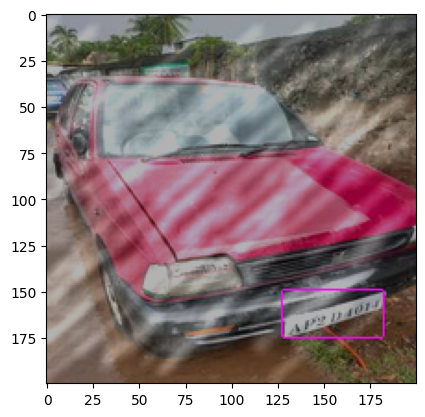

In [30]:
out=post_processing([img],bbox,nfactor=200)
if bbox.size<1 : print(True) 
else:print(False)
img.shape,bbox.shape


In [29]:
mfactor=4
N_images=mfactor*xtrain_2.shape[0]+xtrain_2.shape[0]
X_trans=np.zeros((N_images,200,200,3),dtype=np.uint8)
Y_trans=np.zeros((N_images,4))
count=0
for i in tqdm(range(xtrain_2.shape[0])):
    # print(xtrain_2[i].shape,ytrain_2[i].shape)
    x=xtrain_2[i]
    y=ytrain_2[i]    
    X_trans[count]=x
    Y_trans[count]=y
    count+=1
    for j in range(mfactor):

        try:
            aug=train_transform(image=x,bboxes=list([y]),class_labels=["NP"])
                   
            img=aug["image"]
            bbox=np.array(aug["bboxes"])
            if bbox.size<1 : 
                bbox=[[0,0,0,0]]
            X_trans[count]=img
            Y_trans[count]=bbox
            count+=1
        except:
            pass

    if count%1000==0:
        print(count)
    
        
        
    

 16%|████████████▋                                                                  | 202/1255 [00:02<00:13, 79.79it/s]

1000


 33%|█████████████████████████▉                                                     | 412/1255 [00:05<00:11, 74.38it/s]

2000


 49%|██████████████████████████████████████▍                                        | 611/1255 [00:08<00:08, 74.13it/s]

3000


 65%|███████████████████████████████████████████████████                            | 812/1255 [00:10<00:05, 74.26it/s]

4000


100%|██████████████████████████████████████████████████████████████████████████████| 1255/1255 [00:16<00:00, 73.93it/s]


In [39]:
X_trans.shape,Y_trans.shape

((6271, 200, 200, 3), (6271, 4))

In [31]:
X_trans.dtype

dtype('uint8')

In [32]:
X_trans=X_trans[:-4]
Y_trans=Y_trans[:-4]


111 176 16 118


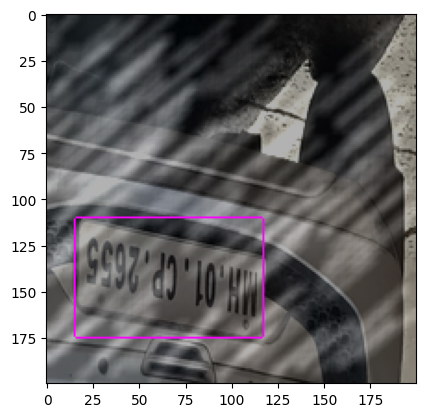

In [33]:
out=post_processing([X_trans[-1]],[Y_trans[-1]])

# Model Training

In [ ]:
# images = os.listdir("State-wise_OLX/")
# images = [i for i in images if "jpg" in i or ".png" in i]
# len(images)

# images[0]

# images_1 = os.listdir("video_images/")
# images_1 = [i for i in images_1 if "jpg" in i or ".png" in i]
# len(images_1)

# images_1[0]


# box = os.listdir("State-wise_OLX/")
# box = [i for i in box if "xml" in i]
# len(box)

# box[0]

# box_1 = os.listdir("video_images/")
# box_1 = [i for i in box_1 if "xml" in i]
# len(box_1)

# box_1[0]



# def create_dataset(x_paths,y_paths,dir_path="State-wise_OLX/"):
    
#     size=200
#     X=np.zeros((len(x_paths),size,size,3),np.uint8)
#     for i in range(len(x_paths)):
#         img=Image.open(dir_path+x_paths[i])
#         img=img.resize((size,size),Image.LANCZOS)
#         img=np.array(img)
#         X[i]=img    

#     Y=np.zeros((len(y_paths),4),np.float16)
#     for i in range(len(y_paths)):        
        
#         with open(dir_path+y_paths[i],"r") as f:
#             data=f.read()
#             data=xmltodict.parse(data)
    
#         cord=data["annotation"]['object']["bndbox"]
#         shape=(int(data["annotation"]["size"]["height"]),int(data["annotation"]["size"]["width"]))

#         buffer=0
#         arr1=np.array([int(cord["ymin"])-buffer,int(cord["xmin"])-buffer,int(cord["ymax"])+buffer,int(cord["xmax"])+buffer],np.float16)
        
        
#         # normalizing 
#         width=arr1[3]-arr1[1]
#         height=arr1[2]-arr1[0]

#         x_center=(arr1[1]+arr1[3])/2
#         y_center=(arr1[0]+arr1[2])/2
        
#         arr1[0] = (x_center)/shape[1]
#         arr1[1] = (y_center)/shape[0]
#         arr1[2] = (width)/shape[1]
#         arr1[3] = (height)/shape[0]

#         Y[i]=arr1   
    

#     return X,Y
    
    
    

# xtrain,ytrain=create_dataset(images,box)
# xtrain.shape,ytrain.shape

# xtrain_1,ytrain_1=create_dataset(images_1,box_1,dir_path="video_images/")
# xtrain_1.shape,ytrain_1.shape


# # a=np.zeros((10,200,200,3))
# # b=np.zeros((11,200,200,3))
# # np.concatenate((a,b),axis=0).shape
# # np.zeros((1,2),dtype=bool)

# xtrain_2=np.concatenate((xtrain,xtrain_1),axis=0)

# ytrain_2=np.concatenate((ytrain,ytrain_1),axis=0)


In [ ]:
# ytrain_2=np.clip(ytrain_2,0.0,1.0)

# xtrain_2.dtype,ytrain_2.dtype

# xtrain_2.shape,ytrain_2.shape


In [110]:
# def draw(img,cords,color=[255,0,255],thickness_n=0,save=False,imp="images/",mp="masks/",idx=None):
#     y1=int(round(cords[0],1))
#     y2=int(round(cords[2],1))
#     x1=int(round(cords[1],1))
#     x2=int(round(cords[3],1))
#     # print(y1,y2,x1,x2)
#     mask=np.zeros((img.shape[0],img.shape[1]),dtype=bool)
    
#     for i in range(y1,y2-1,1):        
#         mask[i][x1-1]=True
#         mask[i][x2-1]=True
#         try:
#             for n in range(thickness_n):
#                 mask[i][x1-n]=True
#                 mask[i][x2-n]=True
#                 mask[i][x1+n]=True
#                 mask[i][x2+n]=True
#         except:
#             pass
    
#     for i in range(x1,x2-1,1):        
#         mask[y1-1][i]=True
#         mask[y2-1][i]=True
#         try:
#             for n in range(thickness_n):
#                 mask[y1-n][i]=True
#                 mask[y2-n][i]=True
#                 mask[y1+n][i]=True
#                 mask[y2+n][i]=True
#         except:
#             pass
#     if save:
#         plt.imsave(imp+f"image{idx}.png",img,cmap="gray")
        
#         plt.imsave(mp+f"mask{idx}.png",mask,cmap="gray")
        
#         # plt.imshow(mask,cmap="gray")
#         # plt.show()
    
#     return img

In [111]:
# def post_processing(img,img_pre,nfactor=200,thickness=0,save=False,imp="images/",mp="masks/",idx=None):
#     pre=(img_pre)[0]*nfactor
    
#     xc=pre[0]
#     yc=pre[1]
#     w=pre[2]
#     h=pre[3]
    
#     xmin=xc-(w/2)
#     ymin=yc-(h/2)
#     xmax=xc+(w/2)
#     ymax=yc+(h/2)
    
#     tem=draw(img[0],[ymin,xmin,ymax,xmax],thickness_n=thickness,save=save,idx=idx)
    
    
#     # print([ymin,ymax,xmin,xmax])
#     plt.imshow(tem)
#     return tem

In [109]:
# for i in range(xtrain_2.shape[0]):
#     print(i)
#     out=post_processing(xtrain_2[i:i+1],ytrain_2[i:i+1],nfactor=200,thickness=2,save=True,idx=i)
